# **HTIN5005 - Assignment 2 (Hospital Admission)**

Alfian Nurfaizi (SID 550180999) <br>
Master of Digital Health and Data Science <br>

SCI-XAI Pipeline adapted from https://github.com/petmoreno/SCI-XAI-Pipeline.git

In [67]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [68]:
#Change Directory
%cd /content/drive/MyDrive/HTIN5005

/content/drive/MyDrive/HTIN5005


# **Import Libraries**

In [69]:
#Import general libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#Import libraries for building the pipeline and join their branches
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin

#Import SCI-XAI modules created for data preparation phase
import my_utils
import missing_val_imput
import feature_select
import preprocessing
import adhoc_transf

#Import libraries for data preparation phase
from sklearn.preprocessing import MinMaxScaler, OrdinalEncoder, LabelEncoder, OneHotEncoder


#Import libraries from modelling phase
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import matthews_corrcoef

#Import Ensemble Trees Classifiers
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier,AdaBoostClassifier,GradientBoostingClassifier,VotingClassifier
import xgboost as xgb

#To save model fit with and avoid longer waits
import joblib
import os

# **Import Dataset**

In [70]:
#Loading the dataset
path_data=r'/content/drive/MyDrive/HTIN5005/Dataset.csv'

df=pd.read_csv(path_data)
df.head()

,Group,Sex,Age,Patients number per hour,Arrival mode,Injury,Chief_complain,Mental,Pain,NRS_pain,...,BT,Saturation,KTAS_RN,Diagnosis in ED,Disposition,KTAS_expert,Error_group,Length of stay_min,KTAS duration_min,mistriage
0,2,2,71,3,3,2,right ocular pain,1,1,2.0,...,36.6,100.0,2,Corneal abrasion,1,4,2,86,5.00,1
1,1,1,56,12,3,2,right forearm burn,1,1,2.0,...,36.5,NaN,4,"Burn of hand, firts degree dorsum",1,5,4,64,3.95,1
2,2,1,68,8,2,2,"arm pain, Lt",1,1,2.0,...,36.6,98.0,4,"Fracture of surgical neck of humerus, closed",2,5,4,862,1.00,1
3,1,2,71,8,1,1,ascites tapping,1,1,3.0,...,36.5,NaN,4,Alcoholic liver cirrhosis with ascites,1,5,6,108,9.83,1
4,1,2,58,4,3,1,"distension, abd",1,1,3.0,...,36.5,NaN,4,Ascites,1,5,8,109,6.60,1


In [71]:
#Drop unused features
df=df.drop(['Patients number per hour','Error_group','KTAS duration_min', 'mistriage'],axis=1)

In [72]:
#Define the mapping
mapping = {
    'Group': {1: 'Local ED', 2: 'Regional ED'},
    'Sex': {1: 'Female', 2: 'Male'},
    'Arrival mode': {1: 'Walking', 2: '119 use', 3: 'Private car', 4: 'Private ambulance', 5: 'Public transportation', 6: 'Wheelchair', 7: 'Others'},
    'Injury': {1: 'Non-injury', 2: 'Injury'},
    'Mental': {1: 'Alert', 2: 'Verbal response', 3: 'Pain response', 4: 'Unconciousness'},
    'Pain': {1: 'Pain', 2: 'Non-pain'},
    'Disposition': {1: 'Discharge', 2: 'Admission', 3: 'Admission', 4: 'Admission', 5: 'Admission', 6: 'Admission', 7: 'Discharge'}
}

# Replace numerical values with categorical labels
df.replace(mapping, inplace=True)

# Display the first few rows to show the changes
display(df.head())

,Group,Sex,Age,Arrival mode,Injury,Chief_complain,Mental,Pain,NRS_pain,SBP,DBP,HR,RR,BT,Saturation,KTAS_RN,Diagnosis in ED,Disposition,KTAS_expert,Length of stay_min
0,Regional ED,Male,71,Private car,Injury,right ocular pain,Alert,Pain,2.0,160.0,100.0,84.0,18.0,36.6,100.0,2,Corneal abrasion,Discharge,4,86
1,Local ED,Female,56,Private car,Injury,right forearm burn,Alert,Pain,2.0,137.0,75.0,60.0,20.0,36.5,NaN,4,"Burn of hand, firts degree dorsum",Discharge,5,64
2,Regional ED,Female,68,119 use,Injury,"arm pain, Lt",Alert,Pain,2.0,130.0,80.0,102.0,20.0,36.6,98.0,4,"Fracture of surgical neck of humerus, closed",Admission,5,862
3,Local ED,Male,71,Walking,Non-injury,ascites tapping,Alert,Pain,3.0,139.0,94.0,88.0,20.0,36.5,NaN,4,Alcoholic liver cirrhosis with ascites,Discharge,5,108
4,Local ED,Male,58,Private car,Non-injury,"distension, abd",Alert,Pain,3.0,91.0,67.0,93.0,18.0,36.5,NaN,4,Ascites,Discharge,5,109


In [73]:
#Characterising the dataset
target_feature='Disposition'
numerical_feats=['Age', 'NRS_pain', 'SBP', 'DBP', 'HR', 'RR', 'BT', 'Saturation']
nominal_feats=['Group', 'Sex', 'Arrival mode', 'Injury', 'Pain', 'Chief_complain', 'Diagnosis in ED']
ordinal_feats=['Mental', 'KTAS_RN', 'KTAS_expert']

len_numerical_feats=len(numerical_feats)
len_nominal_feats=len(nominal_feats)
len_ordinal_feats=len(ordinal_feats)

# **Exploratory Data Analysis**

In [74]:
#Statistical analysis
df.describe()

,Age,NRS_pain,SBP,DBP,HR,RR,BT,Saturation,KTAS_RN,KTAS_expert,Length of stay_min
count,1267.000000,711.000000,1242.000000,1238.000000,1247.000000,1245.000000,1249.000000,570.000000,1267.000000,1267.000000,1267.000000
mean,54.423836,4.104079,133.648953,79.780291,83.963111,19.506827,36.580624,97.024561,3.335438,3.265983,11016.102605
std,19.725033,1.419332,27.275639,15.154292,16.644096,2.016649,0.545708,4.350556,0.885391,0.885803,80446.092065
min,16.000000,1.000000,50.000000,31.000000,32.000000,14.000000,35.000000,20.000000,1.000000,1.000000,0.000000
25%,37.000000,3.000000,114.000000,70.000000,72.000000,18.000000,36.200000,97.000000,3.000000,3.000000,133.000000
50%,57.000000,4.000000,130.000000,80.000000,82.000000,20.000000,36.500000,98.000000,3.000000,3.000000,274.000000
75%,71.000000,5.000000,150.000000,90.000000,96.000000,20.000000,36.800000,98.000000,4.000000,4.000000,606.500000
max,96.000000,10.000000,275.000000,160.000000,148.000000,30.000000,41.000000,100.000000,5.000000,5.000000,709510.000000


In [75]:
#Identifying missing values
my_utils.info_adhoc(df)

,% non-null values,non-null values,dtype
Group,100.000000,1267,object
Sex,100.000000,1267,object
Age,100.000000,1267,int64
Arrival mode,100.000000,1267,object
Injury,100.000000,1267,object
Chief_complain,100.000000,1267,object
Mental,100.000000,1267,object
Pain,100.000000,1267,object
NRS_pain,56.116811,711,float64
SBP,98.026835,1242,float64


In [76]:
#Exploring unique characters
my_utils.df_values(df)

*****start of feature  Group *************************
Group
Local ED       688
Regional ED    579
Name: count, dtype: int64
*****end of feature  Group ************************** 

*****start of feature  Sex *************************
Sex
Male      661
Female    606
Name: count, dtype: int64
*****end of feature  Sex ************************** 

*****start of feature  Age *************************
Age
58    37
74    29
68    28
77    28
56    27
      ..
90     1
94     1
93     1
95     1
96     1
Name: count, Length: 81, dtype: int64
*****end of feature  Age ************************** 

*****start of feature  Arrival mode *************************
Arrival mode
Private car              753
119 use                  266
Private ambulance        155
Walking                   79
Wheelchair                10
Public transportation      2
Others                     2
Name: count, dtype: int64
*****end of feature  Arrival mode ************************** 

*****start of feature  Injury *********

# **Data Preprocessing**

In [77]:
#Remove 'NRS_pain' and 'Saturation' feature because it has a rate of non-values under 70%
df=df.drop(['NRS_pain', 'Saturation'],axis=1)

#Rename the numerical, nominal and ordinal feats after removing feature
numerical_feats=['Age', 'SBP', 'DBP', 'HR', 'RR', 'BT']
nominal_feats=['Group', 'Sex', 'Arrival mode', 'Injury', 'Pain', 'Chief_complain', 'Diagnosis in ED']
ordinal_feats=['Mental', 'KTAS_RN', 'KTAS_expert']

len_numerical_feats=len(numerical_feats)
len_nominal_feats=len(nominal_feats)
len_ordinal_feats=len(ordinal_feats)

In [78]:
#Performing numeric cast for numerical features
df.loc[:,numerical_feats]=adhoc_transf.Numeric_Cast_Column().fit_transform(df.loc[:,numerical_feats])
# Removed explicit conversion to integer type as it caused issues with float values.
# The pipeline will handle imputation and scaling for numerical features.

df[numerical_feats].dtypes


>>>>>>>>Calling init() from Numeric_Cast_Column

>>>>>>>>Calling fit() from Numeric_Cast_Column

>>>>>>>>Calling transform() from Numeric_Cast_Column


,0
Age,int64
SBP,float64
DBP,float64
HR,float64
RR,float64
BT,float64


In [79]:
#Performing category cast for nominal features
df.loc[:,nominal_feats]=adhoc_transf.Category_Cast_Column().fit_transform(df.loc[:,nominal_feats])
df[nominal_feats].dtypes


>>>>>>>>Calling init() from Category_Cast_Column

>>>>>>>>Calling fit() from Category_Cast_Column

>>>>>>>>Calling transform() from Category_Cast_Column


,0
Group,object
Sex,object
Arrival mode,object
Injury,object
Pain,object
Chief_complain,object
Diagnosis in ED,object


In [80]:
#Performing category cast for ordinal features
#Convert all ordinal columns to string type before applying the custom transformer
for col in ordinal_feats:
    df[col] = df[col].astype(str)

df.loc[:,ordinal_feats]=adhoc_transf.Category_Cast_Column().fit_transform(df.loc[:,ordinal_feats])
df[ordinal_feats].dtypes


>>>>>>>>Calling init() from Category_Cast_Column

>>>>>>>>Calling fit() from Category_Cast_Column

>>>>>>>>Calling transform() from Category_Cast_Column


,0
Mental,object
KTAS_RN,object
KTAS_expert,object


In [81]:
#Transform multiclass variables with only top ten most frequent categories
columns_to_transform = ['Chief_complain', 'Diagnosis in ED']
num_top_categories = 10

for col in columns_to_transform:
    # Get the top 10 most frequent categories
    top_categories = df[col].value_counts().nlargest(num_top_categories).index.tolist()

    # Replace categories not in the top 10 with 'others'
    df[col] = df[col].apply(lambda x: x if x in top_categories else 'Others')

print("Transformation complete for:", columns_to_transform)

Transformation complete for: ['Chief_complain', 'Diagnosis in ED']


In [82]:
#Exploring wrong characters
my_utils.df_values(df)

*****start of feature  Group *************************
Group
Local ED       688
Regional ED    579
Name: count, dtype: int64
*****end of feature  Group ************************** 

*****start of feature  Sex *************************
Sex
Male      661
Female    606
Name: count, dtype: int64
*****end of feature  Sex ************************** 

*****start of feature  Age *************************
Age
58    37
74    29
68    28
77    28
56    27
      ..
90     1
94     1
93     1
95     1
96     1
Name: count, Length: 81, dtype: int64
*****end of feature  Age ************************** 

*****start of feature  Arrival mode *************************
Arrival mode
Private car              753
119 use                  266
Private ambulance        155
Walking                   79
Wheelchair                10
Public transportation      2
Others                     2
Name: count, dtype: int64
*****end of feature  Arrival mode ************************** 

*****start of feature  Injury *********

# **Train-Test Splitting**

In [83]:
#Split the dataset into train and test
test_ratio_split=0.3
train_set,test_set=train_test_split(df, test_size=test_ratio_split, random_state=42, stratify=df[target_feature])

X_train=train_set.drop(target_feature,axis=1)
y_train=train_set[target_feature].copy()

X_test=test_set.drop(target_feature,axis=1)
y_test=test_set[target_feature].copy()

# **Label Encoding for Target Value**

In [84]:
le=LabelEncoder()
y_train=le.fit_transform(y_train)
y_test=le.fit_transform(y_test)
le.classes_

array(['Admission', 'Discharge'], dtype=object)

# **Build Data Preparation Pipeline**

In [85]:
# Handle missing custom modules
if 'missing_val_imput' not in globals():
    from sklearn.impute import SimpleImputer
    # Create dummy classes to mimic the expected structure if modules are missing
    class Numeric_Imputer(SimpleImputer):
        def __init__(self, strategy='median'):
            super().__init__(strategy=strategy)

    class Category_Imputer(SimpleImputer):
        def __init__(self, strategy='most_frequent'):
            super().__init__(strategy=strategy)

    # Use SimpleImputer from sklearn as a fallback
    print("Warning: 'missing_val_imput' module not found. Using sklearn.impute.SimpleImputer as fallback.")
    missing_val_imput = globals() # To allow access like missing_val_imput.Numeric_Imputer
    missing_val_imput['Numeric_Imputer'] = Numeric_Imputer
    missing_val_imput['Category_Imputer'] = Category_Imputer

In [86]:
if 'feature_select' not in globals():
    from sklearn.feature_selection import RFE, SelectKBest, f_classif, mutual_info_classif
    from sklearn.ensemble import RandomForestClassifier
    # Create a dummy class to mimic the expected structure
    class Feature_Selector(BaseEstimator, TransformerMixin):
        def __init__(self, strategy='wrapper_RFECV', k_out_features=5):
            self.strategy = strategy
            self.k_out_features = k_out_features
            print(f"Warning: 'feature_select' module not found. Using sklearn equivalents for strategy={strategy}.")

        def fit(self, X, y=None):
            if self.strategy == 'wrapper_RFECV' or self.strategy == 'wrapper_RFE':
                # RFECV is slow, use RFE for demonstration
                self.selector = RFE(RandomForestClassifier(random_state=42, n_estimators=50), n_features_to_select=self.k_out_features)
            elif self.strategy == 'filter_num':
                self.selector = SelectKBest(f_classif, k=self.k_out_features)
            elif self.strategy == 'filter_cat' or self.strategy == 'filter_mutinf':
                self.selector = SelectKBest(mutual_info_classif, k=self.k_out_features)
            else:
                # Default fallback
                self.selector = SelectKBest(f_classif, k=self.k_out_features)

            # Handle NaNs before fitting selector
            X_imputed = SimpleImputer(strategy='median').fit_transform(X)
            self.selector.fit(X_imputed, y)
            return self

        def transform(self, X, y=None):
            X_imputed = SimpleImputer(strategy='median').fit_transform(X)
            return self.selector.transform(X_imputed)

    feature_select = globals()
    feature_select['Feature_Selector'] = Feature_Selector

### **Pipeline Model**
Lets define 3 pipeline model: <br>
a) Parallel approach where feature selection is performed in parallel for numerical, nominal and categorical. <br>
b) General approach where feature selection is performed as a whole for other features. <br>
c) No feature selection is performed.

In [87]:
#Before a data preprocessing will take place for each type of feature
pipeline_numeric_feat=Pipeline([ ('data_missing',missing_val_imput.Numeric_Imputer(strategy='median')),
                                 ('scaler', MinMaxScaler())])

pipeline_nominal_feat=Pipeline([('data_missing',missing_val_imput.Category_Imputer()),
                                 ('encoding', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))])#We dont use OneHotEncoder since it enlarges the number of nominal features

pipeline_ordinal_feat=Pipeline([ ('data_missing',missing_val_imput.Category_Imputer(strategy='most_frequent')),
                                 ('encoding', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))])


 Sun Oct 26 07:22:20 2025 >>>>>>>>Calling init() from Numeric_Imputer

 Sun Oct 26 07:22:20 2025 >>>>>>>>Calling init() from Category_Imputer

 Sun Oct 26 07:22:20 2025 >>>>>>>>Calling init() from Category_Imputer


In [88]:
#Option A
pipe_numeric_featsel=Pipeline([('data_prep',pipeline_numeric_feat),
                                ('feat_sel',feature_select.Feature_Selector(strategy='wrapper_RFECV') )])
pipe_nominal_featsel=Pipeline([('data_prep',pipeline_nominal_feat),
                                ('feat_sel',feature_select.Feature_Selector(strategy='wrapper_RFECV') )])
pipe_ordinal_featsel=Pipeline([('data_prep',pipeline_ordinal_feat),
                                ('feat_sel',feature_select.Feature_Selector(strategy='wrapper_RFECV') )])

dataprep_pipe_opta=ColumnTransformer([('numeric_pipe',pipe_numeric_featsel,numerical_feats),
                                    ('nominal_pipe',pipe_nominal_featsel,nominal_feats),
                                    ('ordinal_pipe',pipe_ordinal_featsel,ordinal_feats)
                                ], remainder='passthrough')


 Sun Oct 26 07:22:20 2025 >>>>>>>>Calling init() from Feature_Selector

 Sun Oct 26 07:22:20 2025 >>>>>>>>Calling init() from Feature_Selector

 Sun Oct 26 07:22:20 2025 >>>>>>>>Calling init() from Feature_Selector


In [89]:
#Option B
dataprep_merge_feat=ColumnTransformer([('numeric_pipe',pipeline_numeric_feat,numerical_feats),
                                    ('nominal_pipe',pipeline_nominal_feat, nominal_feats),
                                    ('ordinal_pipe',pipeline_ordinal_feat,ordinal_feats)
                                ], remainder='passthrough') # Added remainder='passthrough'
dataprep_pipe_optb=Pipeline([('data_prep',dataprep_merge_feat),
                                ('feat_sel',feature_select.Feature_Selector(strategy='wrapper_RFECV') )])


 Sun Oct 26 07:22:20 2025 >>>>>>>>Calling init() from Feature_Selector


In [90]:
#Option C
dataprep_merge_feat

ColumnTransformer(remainder='passthrough',
                  transformers=[('numeric_pipe',
                                 Pipeline(steps=[('data_missing',
                                                  Numeric_Imputer()),
                                                 ('scaler', MinMaxScaler())]),
                                 ['Age', 'SBP', 'DBP', 'HR', 'RR', 'BT']),
                                ('nominal_pipe',
                                 Pipeline(steps=[('data_missing',
                                                  Category_Imputer()),
                                                 ('encoding',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=-1))]),
                                 ['Group', 'Sex', 'Arrival mode', 'Injury',
                                  'Pain', 'Chief_complain',
                                  'Diagnosis in ED']),
                                ('ordinal_pipe',
                                 Pipeline(steps=[('data_missing',
                                                  Category_Imputer()),
                                                 ('encoding',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=-1))]),
                                 ['Mental', 'KTAS_RN', 'KTAS_expert'])])

In [91]:
# Test fitting one pipe to see if it works
try:
    pipe_nominal_featsel.fit_transform(X_train[nominal_feats],y_train)
    print("Test fit of pipe_nominal_featsel successful.")
except Exception as e:
    print(f"Error fitting pipe_nominal_featsel: {e}")
    print("Check your custom modules (missing_val_imput, feature_select) or data.")


 Sun Oct 26 07:22:20 2025 >>>>>>>>Calling fit() from Category_Imputer

 Sun Oct 26 07:22:20 2025 >>>>>>>>Calling transform() from Category_Imputer

 Sun Oct 26 07:22:20 2025 >>>>>>>>Calling fit() from Feature_Selector

 Sun Oct 26 07:22:20 2025 ********Inside fit() from Feature_Selector - self.feat_sel:  RFECV(estimator=LogisticRegression(max_iter=2000))

 Sun Oct 26 07:22:21 2025 >>>>>>>>Calling transform() from Feature_Selector
Test fit of pipe_nominal_featsel successful.


# **Classifier Initialisation**

In [92]:
#Several ensemble classifier with Cross validation will be applied
#We take decision tree as base classifier

dectree_clf=DecisionTreeClassifier(random_state=42)
rndforest_clf=RandomForestClassifier(random_state=42)
extratree_clf=ExtraTreesClassifier(random_state=42)
ada_clf= AdaBoostClassifier(random_state=42)
xgboost_clf= xgb.XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
gradboost_clf=GradientBoostingClassifier(random_state=42)
voting_clf=VotingClassifier(estimators=[('rdf', rndforest_clf), ('xtra', extratree_clf), ('ada', ada_clf)], voting='soft')


# **Scoring Initialisation**

In [93]:
#Define the scoring for the RandomizedSearchCV
scoring = {
    'accuracy': make_scorer(accuracy_score),
    'sensitivity': make_scorer(recall_score),
    'specificity': make_scorer(recall_score,pos_label=0),
    'precision':make_scorer(precision_score),
    'f1':make_scorer(f1_score),
    'roc_auc':make_scorer(roc_auc_score),
    'mcc':make_scorer(matthews_corrcoef)
}

# **Training Data with RandomizedSearchCV**

In [94]:
#Define number of iterations for RandomizedSearchCV
N_ITER_SEARCH = 100
print(f"Running RandomizedSearchCV with n_iter={N_ITER_SEARCH}")

Running RandomizedSearchCV with n_iter=100


## **Model A. Parallel Approach**

In [95]:
full_parallel_pipe_opta=Pipeline([('data_prep',dataprep_pipe_opta),('clf',dectree_clf)])
full_parallel_pipe_opta.get_params().keys()

dict_keys(['memory', 'steps', 'transform_input', 'verbose', 'data_prep', 'clf', 'data_prep__force_int_remainder_cols', 'data_prep__n_jobs', 'data_prep__remainder', 'data_prep__sparse_threshold', 'data_prep__transformer_weights', 'data_prep__transformers', 'data_prep__verbose', 'data_prep__verbose_feature_names_out', 'data_prep__numeric_pipe', 'data_prep__nominal_pipe', 'data_prep__ordinal_pipe', 'data_prep__numeric_pipe__memory', 'data_prep__numeric_pipe__steps', 'data_prep__numeric_pipe__transform_input', 'data_prep__numeric_pipe__verbose', 'data_prep__numeric_pipe__data_prep', 'data_prep__numeric_pipe__feat_sel', 'data_prep__numeric_pipe__data_prep__memory', 'data_prep__numeric_pipe__data_prep__steps', 'data_prep__numeric_pipe__data_prep__transform_input', 'data_prep__numeric_pipe__data_prep__verbose', 'data_prep__numeric_pipe__data_prep__data_missing', 'data_prep__numeric_pipe__data_prep__scaler', 'data_prep__numeric_pipe__data_prep__data_missing__strategy', 'data_prep__numeric_pipe

In [96]:
#Load or save the model saved to avoid a new fitting
path_model_a = r'/content/drive/MyDrive/HTIN5005/GridSearchCV_results/clf_fpipe_a_random.pkl'
path_results_train_a = r'/content/drive/MyDrive/HTIN5005/GridSearchCV_results/train_results_clf_fpipe_a_random.xlsx'
path_results_test_a = r'/content/drive/MyDrive/HTIN5005/GridSearchCV_results/test_results_y_pred_clf_fpipe_a_random.xlsx'

In [97]:
try:
    clf_fpipe_a= joblib.load(path_model_a)
    print("Loaded model 'a' from disk.")
except FileNotFoundError:
    print(f"Model file not found at {path_model_a}. Fitting new model.")
    clf_fpipe_a = None
except Exception as e:
    print(f"Error loading model: {e}. Fitting new model.")
    clf_fpipe_a = None

Loaded model 'a' from disk.


In [98]:
# RandomizedSearchCV samples from these lists.
param_grid_fpipe_a={'clf':[dectree_clf, rndforest_clf, extratree_clf, ada_clf, xgboost_clf,gradboost_clf,voting_clf ],
                    'data_prep__numeric_pipe__data_prep__data_missing__strategy':['mean','median'],
                    'data_prep__numeric_pipe__feat_sel__k_out_features':[*range(1,len_numerical_feats+1)],
                    'data_prep__numeric_pipe__feat_sel__strategy':['filter_num','filter_mutinf','wrapper_RFE'],
                    'data_prep__nominal_pipe__feat_sel__k_out_features':[*range(1,len_nominal_feats+1)],
                    'data_prep__nominal_pipe__feat_sel__strategy':['filter_cat','filter_mutinf','wrapper_RFE'],
                    'data_prep__ordinal_pipe__feat_sel__k_out_features':[*range(1,len_ordinal_feats+1)],
                    'data_prep__ordinal_pipe__feat_sel__strategy':['filter_cat','filter_mutinf','wrapper_RFE']
                    }

In [99]:
if clf_fpipe_a is None or not hasattr(clf_fpipe_a, 'best_estimator_'):
    print("Model 'a' not found or not fitted. Fitting new model.")
    clf_fpipe_a=RandomizedSearchCV(full_parallel_pipe_opta,
                                 param_distributions=param_grid_fpipe_a,
                                 n_iter=N_ITER_SEARCH,
                                 scoring=scoring,
                                 refit='accuracy',
                                 cv=5,
                                 n_jobs=-1,
                                 random_state=42)
    print("Fitting model 'a'...")
    clf_fpipe_a.fit(X_train,y_train)
    print("Fit complete.")

    #Saving the model
    try:
        joblib.dump(clf_fpipe_a, path_model_a, compress=1)
        print(f"Model 'a' saved to {path_model_a}")
    except Exception as e:
        print(f"Error saving model 'a': {e}")
else:
    print("Skipping fit for model 'a' as it was loaded from disk and appears to be fitted.")

Skipping fit for model 'a' as it was loaded from disk and appears to be fitted.


In [100]:
#Printing the best estimator
if hasattr(clf_fpipe_a, 'best_params_'):
    print('Best estimator of clf_fpipe_a:', clf_fpipe_a.best_params_)
    print('Params of best estimator of clf_fpipe_a:', clf_fpipe_a.best_params_)
    print('Score of best estimator of clf_fpipe_a:', clf_fpipe_a.best_score_)
else:
    print("Model 'a' has not been fitted yet. Please run the previous cell to fit the model.")

Best estimator of clf_fpipe_a: {'data_prep__ordinal_pipe__feat_sel__strategy': 'wrapper_RFE', 'data_prep__ordinal_pipe__feat_sel__k_out_features': 2, 'data_prep__numeric_pipe__feat_sel__strategy': 'filter_mutinf', 'data_prep__numeric_pipe__feat_sel__k_out_features': 4, 'data_prep__numeric_pipe__data_prep__data_missing__strategy': 'median', 'data_prep__nominal_pipe__feat_sel__strategy': 'wrapper_RFE', 'data_prep__nominal_pipe__feat_sel__k_out_features': 7, 'clf': GradientBoostingClassifier(random_state=42)}
Params of best estimator of clf_fpipe_a: {'data_prep__ordinal_pipe__feat_sel__strategy': 'wrapper_RFE', 'data_prep__ordinal_pipe__feat_sel__k_out_features': 2, 'data_prep__numeric_pipe__feat_sel__strategy': 'filter_mutinf', 'data_prep__numeric_pipe__feat_sel__k_out_features': 4, 'data_prep__numeric_pipe__data_prep__data_missing__strategy': 'median', 'data_prep__nominal_pipe__feat_sel__strategy': 'wrapper_RFE', 'data_prep__nominal_pipe__feat_sel__k_out_features': 7, 'clf': GradientBoo

In [101]:
if hasattr(clf_fpipe_a, 'best_index_'):
    print('Best index',clf_fpipe_a.best_index_ )

Best index 66


In [102]:
#Saving the training results into dataframe
if hasattr(clf_fpipe_a, 'cv_results_'):
    df_results_clf_fpipe_a=pd.DataFrame(clf_fpipe_a.cv_results_)
    #Create an excel with the cross val resutls
    try:
        df_results_clf_fpipe_a.to_excel(path_results_train_a,index=True)
        print(f"Training results 'a' saved to {path_results_train_a}")
    except Exception as e:
        print(f"Error saving training results 'a': {e}")
else:
    print("No CV results to save for model 'a'.")

Training results 'a' saved to /content/drive/MyDrive/HTIN5005/GridSearchCV_results/train_results_clf_fpipe_a_random.xlsx


In [103]:
#Performing test phase with test set
if hasattr(clf_fpipe_a, 'best_estimator_'):
    clf_fpipe_a.refit
    y_pred_clf_fpipe_a=clf_fpipe_a.predict(X_test)
    test_results_clf_fpipe_a={'clf':['clf_fpipe_a_random'],
                     'params':[clf_fpipe_a.best_params_],
                     'accuracy_test':[accuracy_score(y_test, y_pred_clf_fpipe_a)],
                     'f1_test':[f1_score(y_test, y_pred_clf_fpipe_a)],
                     'precision_test':[precision_score(y_test, y_pred_clf_fpipe_a)],
                     'recall_test':[recall_score(y_test, y_pred_clf_fpipe_a)],
                     'specificity_test':[recall_score(y_test, y_pred_clf_fpipe_a,pos_label=0)],
                     'roc_auc_test':[roc_auc_score(y_test, y_pred_clf_fpipe_a)]
        }

    test_results_y_pred_clf_fpipe_a=pd.DataFrame(data=test_results_clf_fpipe_a)
    try:
        test_results_y_pred_clf_fpipe_a.to_excel(path_results_test_a,index=False)
        print(f"Test results 'a' saved to {path_results_test_a}")
    except Exception as e:
        print(f"Error saving test results 'a': {e}")

    print('Accuracy of test set (model a)',accuracy_score(y_test, y_pred_clf_fpipe_a))
else:
    print("Model 'a' was not fit. Skipping test phase.")


 Sun Oct 26 07:22:21 2025 >>>>>>>>Calling transform() from Numeric_Imputer

 Sun Oct 26 07:22:21 2025 >>>>>>>>Calling transform() from Feature_Selector

 Sun Oct 26 07:22:21 2025 >>>>>>>>Calling transform() from Category_Imputer

 Sun Oct 26 07:22:21 2025 >>>>>>>>Calling transform() from Feature_Selector

 Sun Oct 26 07:22:21 2025 >>>>>>>>Calling transform() from Category_Imputer

 Sun Oct 26 07:22:21 2025 >>>>>>>>Calling transform() from Feature_Selector
Test results 'a' saved to /content/drive/MyDrive/HTIN5005/GridSearchCV_results/test_results_y_pred_clf_fpipe_a_random.xlsx
Accuracy of test set (model a) 0.7611548556430446


/usr/local/lib/python3.12/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


## **Model B. General Approach**

In [104]:
full_parallel_pipe_optb=Pipeline([('data_prep',dataprep_pipe_optb),('clf',dectree_clf)])
full_parallel_pipe_optb.get_params().keys()

dict_keys(['memory', 'steps', 'transform_input', 'verbose', 'data_prep', 'clf', 'data_prep__memory', 'data_prep__steps', 'data_prep__transform_input', 'data_prep__verbose', 'data_prep__data_prep', 'data_prep__feat_sel', 'data_prep__data_prep__force_int_remainder_cols', 'data_prep__data_prep__n_jobs', 'data_prep__data_prep__remainder', 'data_prep__data_prep__sparse_threshold', 'data_prep__data_prep__transformer_weights', 'data_prep__data_prep__transformers', 'data_prep__data_prep__verbose', 'data_prep__data_prep__verbose_feature_names_out', 'data_prep__data_prep__numeric_pipe', 'data_prep__data_prep__nominal_pipe', 'data_prep__data_prep__ordinal_pipe', 'data_prep__data_prep__numeric_pipe__memory', 'data_prep__data_prep__numeric_pipe__steps', 'data_prep__data_prep__numeric_pipe__transform_input', 'data_prep__data_prep__numeric_pipe__verbose', 'data_prep__data_prep__numeric_pipe__data_missing', 'data_prep__data_prep__numeric_pipe__scaler', 'data_prep__data_prep__numeric_pipe__data_missing

In [105]:
#Load the model saved to avoid a new fitting
path_model_b = r'/content/drive/MyDrive/HTIN5005/GridSearchCV_results/clf_fpipe_b_random.pkl'
path_results_train_b = r'/content/drive/MyDrive/HTIN5005/GridSearchCV_results/train_results_clf_fpipe_b_random.xlsx'
path_results_test_b = r'/content/drive/MyDrive/HTIN5005/GridSearchCV_results/test_results_y_pred_clf_fpipe_b_random.xlsx'

try:
    clf_fpipe_b= joblib.load(path_model_b)
    print("Loaded model 'b' from disk.")
except FileNotFoundError:
    print(f"Model file not found at {path_model_b}. Fitting new model.")
    clf_fpipe_b = None
except Exception as e:
    print(f"Error loading model: {e}. Fitting new model.")
    clf_fpipe_b = None

Loaded model 'b' from disk.


In [106]:
param_grid_fpipe_b={'clf':[dectree_clf, rndforest_clf, extratree_clf, ada_clf, xgboost_clf,gradboost_clf,voting_clf ],
                    'data_prep__data_prep__numeric_pipe__data_missing__strategy':['mean','median'],
                    'data_prep__feat_sel__k_out_features':[*range(1,len_numerical_feats+len_nominal_feats+len_ordinal_feats+1)],
                    'data_prep__feat_sel__strategy':['filter_mutinf','wrapper_RFE']
                    }

In [107]:
if clf_fpipe_b is None:
    clf_fpipe_b=RandomizedSearchCV(full_parallel_pipe_optb,
                                 param_distributions=param_grid_fpipe_b,
                                 n_iter=N_ITER_SEARCH,
                                 scoring=scoring,
                                 refit='accuracy',
                                 cv=5,
                                 n_jobs=-1,
                                 random_state=42,
                                 error_score='raise')
    print("Fitting model 'b'...")
    try:
        clf_fpipe_b.fit(X_train,y_train)
        print("Fit complete.")
    except ValueError as e:
        print(f"Error during fitting model 'b': {e}")
        print("Please check data types and pipeline configuration.")


    #Saving the model
    if hasattr(clf_fpipe_b, 'best_estimator_'):
        try:
            joblib.dump(clf_fpipe_b, path_model_b, compress=1)
            print(f"Model 'b' saved to {path_model_b}")
        except Exception as e:
            print(f"Error saving model 'b': {e}")
    else:
        print("Model 'b' was not fit successfully, skipping save.")
else:
    print("Skipping fit for model 'b' as it was loaded from disk.")

Skipping fit for model 'b' as it was loaded from disk.


In [108]:
#Printing the best estimator
if hasattr(clf_fpipe_b, 'best_estimator_'):
    print('Best estimator of clf_fpipe_b:', clf_fpipe_b.best_params_)
    print('Params of best estimator of clf_fpipe_b:', clf_fpipe_b.best_params_)
    print('Score of best estimator of clf_fpipe_b:', clf_fpipe_b.best_score_)
else:
    print("Model 'b' was not fit, so no best estimator to display.")

Best estimator of clf_fpipe_b: {'data_prep__feat_sel__strategy': 'filter_mutinf', 'data_prep__feat_sel__k_out_features': 1, 'data_prep__data_prep__numeric_pipe__data_missing__strategy': 'mean', 'clf': AdaBoostClassifier(random_state=42)}
Params of best estimator of clf_fpipe_b: {'data_prep__feat_sel__strategy': 'filter_mutinf', 'data_prep__feat_sel__k_out_features': 1, 'data_prep__data_prep__numeric_pipe__data_missing__strategy': 'mean', 'clf': AdaBoostClassifier(random_state=42)}
Score of best estimator of clf_fpipe_b: 0.723512981654288


In [109]:
#Saving the training results into dataframe
if hasattr(clf_fpipe_b, 'cv_results_'):
    df_results_clf_fpipe_b=pd.DataFrame(clf_fpipe_b.cv_results_)
    #Create an excel with the cross val resutls
    try:
        df_results_clf_fpipe_b.to_excel(path_results_train_b,index=True)
        print(f"Training results 'b' saved to {path_results_train_b}")
    except Exception as e:
        print(f"Error saving training results 'b': {e}")
else:
    print("No CV results to save for model 'b'.")

Training results 'b' saved to /content/drive/MyDrive/HTIN5005/GridSearchCV_results/train_results_clf_fpipe_b_random.xlsx


In [110]:
#Performing test phase with test set
if hasattr(clf_fpipe_b, 'best_estimator_'):
    clf_fpipe_b.refit
    y_pred_clf_fpipe_b=clf_fpipe_b.predict(X_test)
    test_results_clf_fpipe_b={'clf':['clf_fpipe_b_random'],
                     'params':[clf_fpipe_b.best_params_],
                     'accuracy_test':[accuracy_score(y_test, y_pred_clf_fpipe_b)],
                     'f1_test':[f1_score(y_test, y_pred_clf_fpipe_b)],
                     'precision_test':[precision_score(y_test, y_pred_clf_fpipe_b)],
                     'recall_test':[recall_score(y_test, y_pred_clf_fpipe_b)],
                     'specificity_test':[recall_score(y_test, y_pred_clf_fpipe_b,pos_label=0)],
                     'roc_auc_test':[roc_auc_score(y_test, y_pred_clf_fpipe_b)]
        }

    test_results_y_pred_clf_fpipe_b=pd.DataFrame(data=test_results_clf_fpipe_b)
    try:
        test_results_y_pred_clf_fpipe_b.to_excel(path_results_test_b,index=False)
        print(f"Test results 'b' saved to {path_results_test_b}")
    except Exception as e:
        print(f"Error saving test results 'b': {e}")

    print('Accuracy of test set (model b)',accuracy_score(y_test, y_pred_clf_fpipe_b))
else:
    print("Model 'b' was not fit. Skipping test phase.")


 Sun Oct 26 07:22:22 2025 >>>>>>>>Calling transform() from Numeric_Imputer

 Sun Oct 26 07:22:22 2025 >>>>>>>>Calling transform() from Category_Imputer

 Sun Oct 26 07:22:22 2025 >>>>>>>>Calling transform() from Category_Imputer

 Sun Oct 26 07:22:22 2025 >>>>>>>>Calling transform() from Feature_Selector
Test results 'b' saved to /content/drive/MyDrive/HTIN5005/GridSearchCV_results/test_results_y_pred_clf_fpipe_b_random.xlsx
Accuracy of test set (model b) 0.7427821522309711


/usr/local/lib/python3.12/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


## **Model C. General approach where feature selection is performed as a whole for other features**

In [111]:
full_parallel_pipe_optc=Pipeline([('data_prep',dataprep_merge_feat),('clf',dectree_clf)])
full_parallel_pipe_optc.get_params().keys()

dict_keys(['memory', 'steps', 'transform_input', 'verbose', 'data_prep', 'clf', 'data_prep__force_int_remainder_cols', 'data_prep__n_jobs', 'data_prep__remainder', 'data_prep__sparse_threshold', 'data_prep__transformer_weights', 'data_prep__transformers', 'data_prep__verbose', 'data_prep__verbose_feature_names_out', 'data_prep__numeric_pipe', 'data_prep__nominal_pipe', 'data_prep__ordinal_pipe', 'data_prep__numeric_pipe__memory', 'data_prep__numeric_pipe__steps', 'data_prep__numeric_pipe__transform_input', 'data_prep__numeric_pipe__verbose', 'data_prep__numeric_pipe__data_missing', 'data_prep__numeric_pipe__scaler', 'data_prep__numeric_pipe__data_missing__strategy', 'data_prep__numeric_pipe__scaler__clip', 'data_prep__numeric_pipe__scaler__copy', 'data_prep__numeric_pipe__scaler__feature_range', 'data_prep__nominal_pipe__memory', 'data_prep__nominal_pipe__steps', 'data_prep__nominal_pipe__transform_input', 'data_prep__nominal_pipe__verbose', 'data_prep__nominal_pipe__data_missing', 'da

In [112]:
#Load the model saved to avoid a new fitting
path_model_c = r'/content/drive/MyDrive/HTIN5005/GridSearchCV_results/clf_fpipe_c_random.pkl'
path_results_train_c = r'/content/drive/MyDrive/HTIN5005/GridSearchCV_results/train_results_clf_fpipe_c_random.xlsx'
path_results_test_c = r'/content/drive/MyDrive/HTIN5005/GridSearchCV_results/test_results_y_pred_clf_fpipe_c_random.xlsx'

try:
    clf_fpipe_c= joblib.load(path_model_c)
    print("Loaded model 'c' from disk.")
except FileNotFoundError:
    print(f"Model file not found at {path_model_c}. Fitting new model.")
    clf_fpipe_c = None
except Exception as e:
    print(f"Error loading model: {e}. Fitting new model.")
    clf_fpipe_c = None

Loaded model 'c' from disk.


In [113]:
param_grid_fpipe_c={'clf':[dectree_clf, rndforest_clf, extratree_clf, ada_clf, xgboost_clf,gradboost_clf,voting_clf ],
                    'data_prep__numeric_pipe__data_missing__strategy':['mean','median']
                    }

In [114]:
if clf_fpipe_c is None:
    clf_fpipe_c=RandomizedSearchCV(full_parallel_pipe_optc,
                                 param_distributions=param_grid_fpipe_c,
                                 n_iter=N_ITER_SEARCH,
                                 scoring=scoring,
                                 refit='accuracy',
                                 cv=5,
                                 n_jobs=None,
                                 random_state=42,
                                 error_score='raise')
    print("Fitting model 'c'...")
    try:
        clf_fpipe_c.fit(X_train,y_train)
        print("Fit complete.")
    except ValueError as e:
        print(f"Error during fitting model 'c': {e}")
        print("Please check data types and pipeline configuration.")


    #Saving the model
    if hasattr(clf_fpipe_c, 'best_estimator_'):
        try:
            joblib.dump(clf_fpipe_c, path_model_c, compress=1)
            print(f"Model 'c' saved to {path_model_c}")
        except Exception as e:
            print(f"Error saving model 'c': {e}")
    else:
        print("Model 'c' was not fit successfully, skipping save.")
else:
    print("Skipping fit for model 'c' as it was loaded from disk.")

Skipping fit for model 'c' as it was loaded from disk.


In [115]:
#Printing the best estimator
if hasattr(clf_fpipe_c, 'best_estimator_'):
    print('Best estimator of clf_fpipe_c:', clf_fpipe_c.best_params_)
    print('Params of best estimator of clf_fpipe_c:', clf_fpipe_c.best_params_)
    print('Score of best estimator of clf_fpipe_c:', clf_fpipe_c.best_score_) # Corrected variable
else:
    print("Model 'c' was not fit, so no best estimator to display.")

Best estimator of clf_fpipe_c: {'data_prep__numeric_pipe__data_missing__strategy': 'median', 'clf': GradientBoostingClassifier(random_state=42)}
Params of best estimator of clf_fpipe_c: {'data_prep__numeric_pipe__data_missing__strategy': 'median', 'clf': GradientBoostingClassifier(random_state=42)}
Score of best estimator of clf_fpipe_c: 0.7629911762838825


In [116]:
#Saving the training results into dataframe
if hasattr(clf_fpipe_c, 'cv_results_'):
    df_results_clf_fpipe_c=pd.DataFrame(clf_fpipe_c.cv_results_)
    #Create an excel with the cross val resutls
    try:
        df_results_clf_fpipe_c.to_excel(path_results_train_c,index=True)
        print(f"Training results 'c' saved to {path_results_train_c}")
    except Exception as e:
        print(f"Error saving training results 'c': {e}")
else:
    print("No CV results to save for model 'c'.")

Training results 'c' saved to /content/drive/MyDrive/HTIN5005/GridSearchCV_results/train_results_clf_fpipe_c_random.xlsx


In [117]:
#Performing test phase with test set
if hasattr(clf_fpipe_c, 'best_estimator_'):
    clf_fpipe_c.refit
    y_pred_clf_fpipe_c=clf_fpipe_c.predict(X_test)
    test_results_clf_fpipe_c={'clf':['clf_fpipe_c_random'],
                     'params':[clf_fpipe_c.best_params_],
                     'accuracy_test':[accuracy_score(y_test, y_pred_clf_fpipe_c)],
                     'f1_test':[f1_score(y_test, y_pred_clf_fpipe_c)],
                     'precision_test':[precision_score(y_test, y_pred_clf_fpipe_c)],
                     'recall_test':[recall_score(y_test, y_pred_clf_fpipe_c)],
                     'specificity_test':[recall_score(y_test, y_pred_clf_fpipe_c,pos_label=0)],
                     'roc_auc_test':[roc_auc_score(y_test, y_pred_clf_fpipe_c)]
        }

    test_results_y_pred_clf_fpipe_c=pd.DataFrame(data=test_results_clf_fpipe_c)
    try:
        test_results_y_pred_clf_fpipe_c.to_excel(path_results_test_c,index=False)
        print(f"Test results 'c' saved to {path_results_test_c}")
    except Exception as e:
        print(f"Error saving test results 'c': {e}")

    print('Accuracy of test set (model c)',accuracy_score(y_test, y_pred_clf_fpipe_c))
else:
    print("Model 'c' was not fit. Skipping test phase.")


 Sun Oct 26 07:22:22 2025 >>>>>>>>Calling transform() from Numeric_Imputer

 Sun Oct 26 07:22:22 2025 >>>>>>>>Calling transform() from Category_Imputer

 Sun Oct 26 07:22:22 2025 >>>>>>>>Calling transform() from Category_Imputer
Test results 'c' saved to /content/drive/MyDrive/HTIN5005/GridSearchCV_results/test_results_y_pred_clf_fpipe_c_random.xlsx
Accuracy of test set (model c) 0.7559055118110236


# **Interpretability Analysis**

In [118]:
#Import self-developed interpretability metrics for analysis
import interpretability_metrics as im

In [119]:
#Determine n (total features before selection)
n_total_features = len(numerical_feats) + len(nominal_feats) + len(ordinal_feats)
print(f"Total features considered for selection (n): {n_total_features}")

Total features considered for selection (n): 16


In [120]:
#Interpretability Metrics for Model A
results_a = {'I': np.nan, 'Acc': np.nan, 'AUROC': np.nan, 'AccII': np.nan, 'AUROCII': np.nan}

if im is not None and hasattr(clf_fpipe_a, 'best_estimator_'):
    print("\n--- Calculating Metrics for Model A (Parallel Feature Selection) ---")
    best_model_a = clf_fpipe_a.best_estimator_
    best_params_a = clf_fpipe_a.best_params_

    # Determine k for Model A
    k_numeric_a = best_params_a.get('data_prep__numeric_pipe__feat_sel__k_out_features', 0)
    k_nominal_a = best_params_a.get('data_prep__nominal_pipe__feat_sel__k_out_features', 0)
    k_ordinal_a = best_params_a.get('data_prep__ordinal_pipe__feat_sel__k_out_features', 0)
    k_a = k_numeric_a + k_nominal_a + k_ordinal_a
    print(f"Features used by Model A (k): {k_a}")

    y_pred_a = best_model_a.predict(X_test)

    # Get scores for AUROCII
    y_scores_a = None
    if hasattr(best_model_a, "predict_proba"):
        y_scores_a = best_model_a.predict_proba(X_test)[:, 1]
    elif hasattr(best_model_a, "decision_function"):
        try:
           y_scores_a = best_model_a.decision_function(X_test)
           if y_scores_a.ndim > 1 and y_scores_a.shape[1] > 1: y_scores_a = y_scores_a[:, 1]
        except Exception as e: print(f"Could not get decision_function scores for Model A: {e}")
    else: print("Model A classifier does not support predict_proba or decision_function.")


    # Calculate metrics
    results_a['I'] = im.calculate_interpretability(k=k_a, n=n_total_features)
    results_a['Acc'] = accuracy_score(y_test, y_pred_a)
    results_a['AccII'] = im.calculate_accii(y_test, y_pred_a, k=k_a, n=n_total_features, alpha=0.5)

    if y_scores_a is not None:
        try:
            results_a['AUROC'] = roc_auc_score(y_test, y_scores_a)
            results_a['AUROCII'] = im.calculate_aurocii(y_test, y_scores_a, k=k_a, n=n_total_features, alpha=0.5)
        except ValueError as e:
            print(f"Could not calculate AUROC/AUROCII for Model A: {e}")
    else:
         print("Cannot calculate AUROC/AUROCII for Model A as scores are unavailable.")

    print(f"Interpretability (I): {results_a['I']:.4f}")
    print(f"Accuracy: {results_a['Acc']:.4f}")
    print(f"AUROC: {results_a['AUROC']:.4f}")
    print(f"AccII (alpha=0.5): {results_a['AccII']:.4f}")
    print(f"AUROCII (alpha=0.5): {results_a['AUROCII']:.4f}")

else:
    print("\nSkipping metrics calculation for Model A (module not loaded or model not fitted).")


--- Calculating Metrics for Model A (Parallel Feature Selection) ---
Features used by Model A (k): 13

 Sun Oct 26 07:22:22 2025 >>>>>>>>Calling transform() from Numeric_Imputer

 Sun Oct 26 07:22:22 2025 >>>>>>>>Calling transform() from Feature_Selector

 Sun Oct 26 07:22:22 2025 >>>>>>>>Calling transform() from Category_Imputer

 Sun Oct 26 07:22:22 2025 >>>>>>>>Calling transform() from Feature_Selector

 Sun Oct 26 07:22:22 2025 >>>>>>>>Calling transform() from Category_Imputer

 Sun Oct 26 07:22:22 2025 >>>>>>>>Calling transform() from Feature_Selector

 Sun Oct 26 07:22:22 2025 >>>>>>>>Calling transform() from Numeric_Imputer

 Sun Oct 26 07:22:22 2025 >>>>>>>>Calling transform() from Feature_Selector

 Sun Oct 26 07:22:22 2025 >>>>>>>>Calling transform() from Category_Imputer

 Sun Oct 26 07:22:22 2025 >>>>>>>>Calling transform() from Feature_Selector

 Sun Oct 26 07:22:22 2025 >>>>>>>>Calling transform() from Category_Imputer

 Sun Oct 26 07:22:22 2025 >>>>>>>>Calling transform

/usr/local/lib/python3.12/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instanc

In [121]:
#Interpretability Metrics for Model B
results_b = {'I': np.nan, 'Acc': np.nan, 'AUROC': np.nan, 'AccII': np.nan, 'AUROCII': np.nan}

if im is not None and hasattr(clf_fpipe_b, 'best_estimator_'):
    print("\n--- Calculating Metrics for Model B (General Feature Selection) ---")
    best_model_b = clf_fpipe_b.best_estimator_
    best_params_b = clf_fpipe_b.best_params_

    # Determine k for Model B
    k_b = best_params_b.get('data_prep__feat_sel__k_out_features', 0)
    print(f"Features used by Model B (k): {k_b}")

    y_pred_b = best_model_b.predict(X_test)

    # Get scores for AUROCII
    y_scores_b = None
    if hasattr(best_model_b, "predict_proba"):
        y_scores_b = best_model_b.predict_proba(X_test)[:, 1]
    elif hasattr(best_model_b, "decision_function"):
         try:
           y_scores_b = best_model_b.decision_function(X_test)
           if y_scores_b.ndim > 1 and y_scores_b.shape[1] > 1: y_scores_b = y_scores_b[:, 1]
         except Exception as e: print(f"Could not get decision_function scores for Model B: {e}")
    else: print("Model B classifier does not support predict_proba or decision_function.")

    # Calculate metrics
    results_b['I'] = im.calculate_interpretability(k=k_b, n=n_total_features)
    results_b['Acc'] = accuracy_score(y_test, y_pred_b)
    results_b['AccII'] = im.calculate_accii(y_test, y_pred_b, k=k_b, n=n_total_features, alpha=0.5)

    if y_scores_b is not None:
         try:
            results_b['AUROC'] = roc_auc_score(y_test, y_scores_b)
            results_b['AUROCII'] = im.calculate_aurocii(y_test, y_scores_b, k=k_b, n=n_total_features, alpha=0.5)
         except ValueError as e:
            print(f"Could not calculate AUROC/AUROCII for Model B: {e}")

    else:
         print("Cannot calculate AUROC/AUROCII for Model B as scores are unavailable.")

    print(f"Interpretability (I): {results_b['I']:.4f}")
    print(f"Accuracy: {results_b['Acc']:.4f}")
    print(f"AUROC: {results_b['AUROC']:.4f}")
    print(f"AccII (alpha=0.5): {results_b['AccII']:.4f}")
    print(f"AUROCII (alpha=0.5): {results_b['AUROCII']:.4f}")

else:
    print("\nSkipping metrics calculation for Model B (module not loaded or model not fitted).")


--- Calculating Metrics for Model B (General Feature Selection) ---
Features used by Model B (k): 1

 Sun Oct 26 07:22:22 2025 >>>>>>>>Calling transform() from Numeric_Imputer

 Sun Oct 26 07:22:22 2025 >>>>>>>>Calling transform() from Category_Imputer

 Sun Oct 26 07:22:22 2025 >>>>>>>>Calling transform() from Category_Imputer

 Sun Oct 26 07:22:22 2025 >>>>>>>>Calling transform() from Feature_Selector

 Sun Oct 26 07:22:22 2025 >>>>>>>>Calling transform() from Numeric_Imputer

 Sun Oct 26 07:22:22 2025 >>>>>>>>Calling transform() from Category_Imputer

 Sun Oct 26 07:22:22 2025 >>>>>>>>Calling transform() from Category_Imputer

 Sun Oct 26 07:22:22 2025 >>>>>>>>Calling transform() from Feature_Selector
Interpretability (I): 1.0000
Accuracy: 0.7428
AUROC: 0.7872
AccII (alpha=0.5): 0.8714
AUROCII (alpha=0.5): 0.8936


/usr/local/lib/python3.12/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


In [122]:
# Interpretability Metrics for Model C
results_c = {'I': np.nan, 'Acc': np.nan, 'AUROC': np.nan, 'AccII': np.nan, 'AUROCII': np.nan}

if im is not None and hasattr(clf_fpipe_c, 'best_estimator_'):
    print("\n--- Calculating Metrics for Model C (No Feature Selection) ---")
    best_model_c = clf_fpipe_c.best_estimator_
    best_params_c = clf_fpipe_c.best_params_

    # Determine k for Model C (no feature selection means k=n)
    k_c = n_total_features
    print(f"Features used by Model C (k): {k_c} (Same as n)")

    y_pred_c = best_model_c.predict(X_test)

    # Get scores for AUROCII
    y_scores_c = None
    if hasattr(best_model_c, "predict_proba"):
        y_scores_c = best_model_c.predict_proba(X_test)[:, 1]
    elif hasattr(best_model_c, "decision_function"):
         try:
           y_scores_c = best_model_c.decision_function(X_test)
           if y_scores_c.ndim > 1 and y_scores_c.shape[1] > 1: y_scores_c = y_scores_c[:, 1]
         except Exception as e: print(f"Could not get decision_function scores for Model C: {e}")
    else: print("Model C classifier does not support predict_proba or decision_function.")


    # Calculate metrics
    results_c['I'] = im.calculate_interpretability(k=k_c, n=n_total_features)
    results_c['Acc'] = accuracy_score(y_test, y_pred_c)
    results_c['AccII'] = im.calculate_accii(y_test, y_pred_c, k=k_c, n=n_total_features, alpha=0.5)

    if y_scores_c is not None:
        try:
            results_c['AUROC'] = roc_auc_score(y_test, y_scores_c)
            results_c['AUROCII'] = im.calculate_aurocii(y_test, y_scores_c, k=k_c, n=n_total_features, alpha=0.5)
        except ValueError as e:
            print(f"Could not calculate AUROC/AUROCII for Model C: {e}")

    else:
        print("Cannot calculate AUROC/AUROCII for Model C as scores are unavailable.")


    print(f"Interpretability (I): {results_c['I']:.4f}")
    print(f"Accuracy: {results_c['Acc']:.4f}")
    print(f"AUROC: {results_c['AUROC']:.4f}")
    print(f"AccII (alpha=0.5): {results_c['AccII']:.4f}")
    print(f"AUROCII (alpha=0.5): {results_c['AUROCII']:.4f}")
else:
    print("\nSkipping metrics calculation for Model C (module not loaded or model not fitted).")


--- Calculating Metrics for Model C (No Feature Selection) ---
Features used by Model C (k): 16 (Same as n)

 Sun Oct 26 07:22:22 2025 >>>>>>>>Calling transform() from Numeric_Imputer

 Sun Oct 26 07:22:22 2025 >>>>>>>>Calling transform() from Category_Imputer

 Sun Oct 26 07:22:22 2025 >>>>>>>>Calling transform() from Category_Imputer

 Sun Oct 26 07:22:22 2025 >>>>>>>>Calling transform() from Numeric_Imputer

 Sun Oct 26 07:22:22 2025 >>>>>>>>Calling transform() from Category_Imputer

 Sun Oct 26 07:22:22 2025 >>>>>>>>Calling transform() from Category_Imputer
Interpretability (I): 0.0000
Accuracy: 0.7559
AUROC: 0.8330
AccII (alpha=0.5): 0.3780
AUROCII (alpha=0.5): 0.4165


In [123]:
#Summary Table
summary_data = {
    'Model': ['Model A (Parallel FS)', 'Model B (General FS)', 'Model C (No FS)'],
    'k (Features Used)': [k_a if 'k_a' in locals() else 'N/A',
                          k_b if 'k_b' in locals() else 'N/A',
                          k_c if 'k_c' in locals() else 'N/A'],
    'n (Total Features)': [n_total_features] * 3,
    'Interpretability (I)': [results_a['I'], results_b['I'], results_c['I']],
    'Accuracy': [results_a['Acc'], results_b['Acc'], results_c['Acc']],
    'AUROC': [results_a['AUROC'], results_b['AUROC'], results_c['AUROC']],
    'AccII (alpha=0.5)': [results_a['AccII'], results_b['AccII'], results_c['AccII']],
    'AUROCII (alpha=0.5)': [results_a['AUROCII'], results_b['AUROCII'], results_c['AUROCII']]
}

df_summary = pd.DataFrame(summary_data)

print("\n--- Interpretability Metrics Summary (Test Set) ---")
display(df_summary.round(4))


--- Interpretability Metrics Summary (Test Set) ---


,Model,k (Features Used),n (Total Features),Interpretability (I),Accuracy,AUROC,AccII (alpha=0.5),AUROCII (alpha=0.5)
0,Model A (Parallel FS),13,16,0.2,0.7612,0.8346,0.4806,0.5173
1,Model B (General FS),1,16,1.0,0.7428,0.7872,0.8714,0.8936
2,Model C (No FS),16,16,0.0,0.7559,0.8330,0.3780,0.4165


In [124]:
#Save the summary
path_summary = r'/content/drive/MyDrive/HTIN5005/GridSearchCV_results/interpretability_summary_allocation.xlsx'
try:
    df_summary.round(4).to_excel(path_summary, index=False)
    print(f"\nSummary saved to {path_summary}")
except Exception as e:
    print(f"\nError saving summary: {e}")


Summary saved to /content/drive/MyDrive/HTIN5005/GridSearchCV_results/interpretability_summary_allocation.xlsx


# **SHAP Explainability**

We will use the best performing model from the RandomizedSearchCV, which appears to be Model A (`clf_fpipe_a`) based on the test accuracy.

In [125]:
# Install shap if not already installed
try:
    import shap
    print(f"SHAP version {shap.__version__} loaded.")
except ImportError:
    print("Installing shap...")
    import shap
    print(f"SHAP version {shap.__version__} installed and loaded.")

SHAP version 0.49.1 loaded.


In [126]:
#Ensure the best model exists and is fitted
if 'clf_fpipe_a' in globals() and clf_fpipe_a is not None and hasattr(clf_fpipe_a, 'best_estimator_'):
    best_model_pipeline = clf_fpipe_a.best_estimator_
    print("\nUsing best model from pipeline 'a' for SHAP analysis.")
    print(f"Best Classifier: {type(best_model_pipeline.named_steps['clf']).__name__}")

    #The best_estimator_ is itself a Pipeline: [('data_prep', ColumnTransformer(...)), ('clf', GradientBoostingClassifier(...))]
    data_prep_step = best_model_pipeline.named_steps['data_prep']
    classifier_step = best_model_pipeline.named_steps['clf']

    #1. Preprocess the data using the fitted data_prep step
    print("\nTransforming data using the best pipeline's data_prep step...")
    try:
        #The data_prep_step should already be fitted within clf_fpipe_a after RandomizedSearchCV's refit
        X_train_transformed = data_prep_step.transform(X_train)
        X_test_transformed = data_prep_step.transform(X_test)
        print(f"Data transformation successful. Transformed train shape: {X_train_transformed.shape}")
    except Exception as e:
        print(f"Error during data transformation: {e}. Attempting to fit_transform X_train...")
        import traceback
        traceback.print_exc()
        try:
            #If transform fails, try fit_transform on train and then transform test
             X_train_transformed = data_prep_step.fit_transform(X_train, y_train)
             X_test_transformed = data_prep_step.transform(X_test)
             print(f"Fit_transform successful. Transformed train shape: {X_train_transformed.shape}")
        except Exception as e_inner:
             print(f"Fallback fit_transform also failed: {e_inner}")
             traceback.print_exc()
             X_train_transformed = None # Indicate failure
             X_test_transformed = None


    #2. Get feature names *after* transformation
    feature_names_transformed = []
    if X_train_transformed is not None:
        try:
            # Attempt to get feature names from the transformer
            # This works well if all inner transformers support get_feature_names_out
            feature_names_transformed = data_prep_step.get_feature_names_out()
            print(f"\nSuccessfully retrieved {len(feature_names_transformed)} transformed feature names.")
            # print("Transformed names:", feature_names_transformed) # Uncomment to see names
        except Exception as e:
            print(f"\nCould not get feature names automatically from transformer: {e}.")
            # Manually construct names based on selected features (more brittle)
            try:
                # Get the boolean mask or indices from each feature selector step
                num_mask = data_prep_step.named_transformers_['numeric_pipe'].named_steps['feat_sel'].selector_.get_support()
                nom_mask = data_prep_step.named_transformers_['nominal_pipe'].named_steps['feat_sel'].selector_.get_support()
                ord_mask = data_prep_step.named_transformers_['ordinal_pipe'].named_steps['feat_sel'].selector_.get_support()

                selected_numeric = [f"num_{name}" for name, kept in zip(numerical_feats, num_mask) if kept]
                selected_nominal = [f"nom_{name}" for name, kept in zip(nominal_feats, nom_mask) if kept]
                selected_ordinal = [f"ord_{name}" for name, kept in zip(ordinal_feats, ord_mask) if kept]

                feature_names_transformed = selected_numeric + selected_nominal + selected_ordinal
                # Add remainder features if any ('passthrough') - Check transformer details
                # This part is complex as remainder columns aren't named by default
                num_output_features = X_train_transformed.shape[1]
                if len(feature_names_transformed) < num_output_features:
                     print("Warning: Manually constructed feature names might not match remainder columns.")
                     remainder_count = num_output_features - len(feature_names_transformed)
                     feature_names_transformed.extend([f"remainder_{i}" for i in range(remainder_count)])

                print(f"Manually constructed {len(feature_names_transformed)} feature names.")

            except Exception as e_manual:
                 print(f"Manual construction of feature names failed: {e_manual}. Using generic names.")
                 num_features = X_train_transformed.shape[1]
                 feature_names_transformed = [f"feature_{i}" for i in range(num_features)]
                 print(f"Using {len(feature_names_transformed)} generic feature names.")


    #Convert transformed data to DataFrame
    X_train_transformed_df = None
    X_test_transformed_df = None
    if X_train_transformed is not None:
        #Convert sparse matrix to dense if necessary
        if hasattr(X_train_transformed, "toarray"):
            X_train_dense = X_train_transformed.toarray()
            X_test_dense = X_test_transformed.toarray()
        else:
            X_train_dense = X_train_transformed
            X_test_dense = X_test_transformed

        #Ensure feature_names match dimension
        if len(feature_names_transformed) != X_train_dense.shape[1]:
            print(f"Warning: Number of feature names ({len(feature_names_transformed)}) does not match number of columns ({X_train_dense.shape[1]}). Using generic names.")
            feature_names_transformed = [f"feature_{i}" for i in range(X_train_dense.shape[1])]


        X_train_transformed_df = pd.DataFrame(X_train_dense, columns=feature_names_transformed, index=X_train.index)
        X_test_transformed_df = pd.DataFrame(X_test_dense, columns=feature_names_transformed, index=X_test.index)
        print("\nCreated DataFrames from transformed data.")


    #3. Initialize SHAP Explainer and Calculate Values
    explainer = None
    shap_values_train = None
    shap_values_test = None
    shap_values_train_pos = None
    shap_values_test_pos = None
    expected_value = None

    if X_train_transformed_df is not None:
        #Check if the classifier is tree-based for TreeExplainer
        if isinstance(classifier_step, (DecisionTreeClassifier, RandomForestClassifier, ExtraTreesClassifier, xgb.XGBClassifier, GradientBoostingClassifier)):
            print("\nUsing TreeExplainer.")
            try:
                #Pass the *DataFrame* of transformed data as background
                explainer = shap.TreeExplainer(classifier_step, X_train_transformed_df)
                # Calculate SHAP values on the *transformed* data (DataFrame)
                shap_values_train = explainer(X_train_transformed_df) # New API call returns Explanation object
                shap_values_test = explainer(X_test_transformed_df)   # New API call

                #For binary classification with new API, shap_values.values often has shape (n_samples, n_features, n_classes)
                # or (n_samples, n_features) if output is single class. Need to check.
                if shap_values_train.values.ndim == 3 and shap_values_train.values.shape[2] == 2:
                    print(f"SHAP values calculated for both classes.")
                    # We usually explain the positive class (class 1)
                    shap_values_train_pos = shap_values_train[:,:,1].values # Get values for class 1
                    shap_values_test_pos = shap_values_test[:,:,1].values   # Get values for class 1
                    expected_value = explainer.expected_value[1] # Expected value for the positive class
                elif shap_values_train.values.ndim == 2:
                     print(f"SHAP values calculated for the positive class.")
                     shap_values_train_pos = shap_values_train.values
                     shap_values_test_pos = shap_values_test.values
                     expected_value = explainer.expected_value
                else:
                     print(f"Unexpected SHAP values shape: {shap_values_train.values.shape}. Cannot proceed with standard plots.")


            except Exception as e_tree:
                 print(f"Error initializing TreeExplainer or calculating SHAP values: {e_tree}")
                 traceback.print_exc()

        else:
            #Fallback for non-tree models (might be slower)
             print("\nClassifier is not tree-based. Using KernelExplainer (can be slow)...")
             try:
                 #KernelExplainer requires a function that takes numpy array and returns model predictions (probabilities for the positive class)
                 def predict_proba_fn(data_np):
                     # Need to convert numpy back to DataFrame with correct columns for the data_prep_step IF IT WASN'T APPLIED ALREADY
                     # Since we already transformed, we pass directly to the classifier step
                     data_df_predict = pd.DataFrame(data_np, columns=feature_names_transformed)
                     return classifier_step.predict_proba(data_df_predict)[:, 1] # Probability of class 1

                 #Summarise background data using kmeans on the *transformed* data (numpy)
                 print("Summarizing background data using kmeans...")
                 X_train_summary_np = shap.kmeans(X_train_transformed_df.values, 25) # Use 25 centroids for summary

                 explainer = shap.KernelExplainer(predict_proba_fn, X_train_summary_np)
                 print("Calculating SHAP values with KernelExplainer (this may take a while)...")
                 #Calculate SHAP values (can be slow) - Pass numpy arrays
                 shap_values_train_pos = explainer.shap_values(X_train_transformed_df.values) # SHAP values for positive class
                 shap_values_test_pos = explainer.shap_values(X_test_transformed_df.values)
                 expected_value = explainer.expected_value
                 print("KernelExplainer SHAP values calculated.")

             except Exception as e_kernel:
                  print(f"Error initializing KernelExplainer or calculating SHAP values: {e_kernel}")
                  traceback.print_exc()

        if shap_values_train_pos is not None:
             print("\nSHAP values calculation step completed.")
        else:
             print("\nSHAP values calculation FAILED.")


    else:
        print("\nTransformed training data is not available. Cannot initialize SHAP explainer.")

else:
    print("\nBest model 'clf_fpipe_a' not found or not fitted. Cannot perform SHAP analysis.")



Using best model from pipeline 'a' for SHAP analysis.
Best Classifier: GradientBoostingClassifier

Transforming data using the best pipeline's data_prep step...

 Sun Oct 26 07:22:22 2025 >>>>>>>>Calling transform() from Numeric_Imputer

 Sun Oct 26 07:22:22 2025 >>>>>>>>Calling transform() from Feature_Selector

 Sun Oct 26 07:22:22 2025 >>>>>>>>Calling transform() from Category_Imputer

 Sun Oct 26 07:22:22 2025 >>>>>>>>Calling transform() from Feature_Selector

 Sun Oct 26 07:22:22 2025 >>>>>>>>Calling transform() from Category_Imputer

 Sun Oct 26 07:22:22 2025 >>>>>>>>Calling transform() from Feature_Selector

 Sun Oct 26 07:22:22 2025 >>>>>>>>Calling transform() from Numeric_Imputer

 Sun Oct 26 07:22:22 2025 >>>>>>>>Calling transform() from Feature_Selector

 Sun Oct 26 07:22:22 2025 >>>>>>>>Calling transform() from Category_Imputer

 Sun Oct 26 07:22:22 2025 >>>>>>>>Calling transform() from Feature_Selector

 Sun Oct 26 07:22:22 2025 >>>>>>>>Calling transform() from Category_I

/usr/local/lib/python3.12/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instanc

SHAP values calculated for the positive class.

SHAP values calculation step completed.


## **Global Explainability**

Generating SHAP Summary Plot (Bar) - Customised...


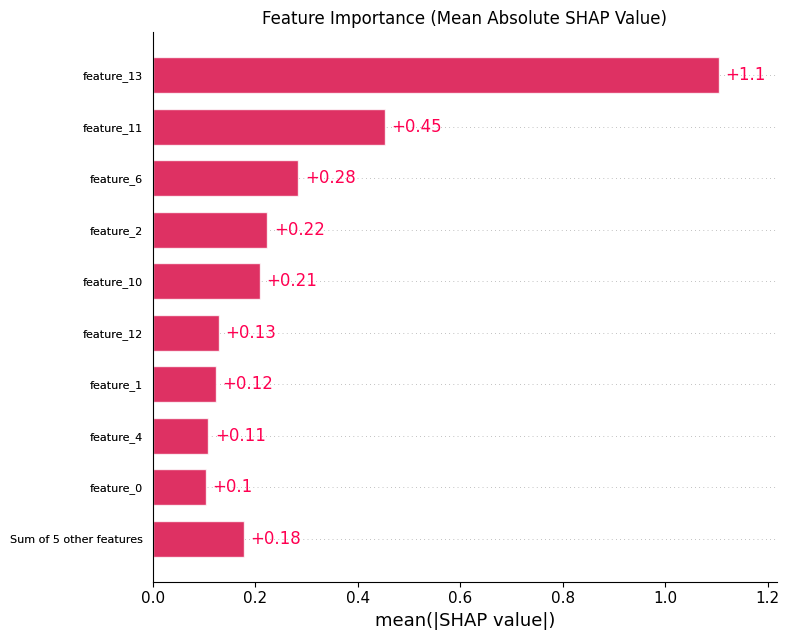

In [127]:
#Summary Plot (Bar) - Shows mean absolute SHAP value for each feature
if shap_values_train_pos is not None and X_train_transformed_df is not None and feature_names_transformed:
    print("Generating SHAP Summary Plot (Bar) - Customised...")
    try:
        # Create the Explanation object
        shap_explanation_train = shap.Explanation(
            values=shap_values_train_pos,
            base_values=expected_value if expected_value is not None and np.isscalar(expected_value) else np.mean(expected_value) if expected_value is not None else 0,
            data=X_train_transformed_df.values,
            feature_names=feature_names_transformed
        )

        plt.figure()
        shap.plots.bar(shap_explanation_train,
                       show=False)

        #Customise the plot further if needed (using matplotlib)
        plt.title("Feature Importance (Mean Absolute SHAP Value)")
        #Find the axes created by shap.plots.bar and change bar color
        ax = plt.gca()
        for patch in ax.patches:
            patch.set_facecolor('#DE3163')

        #Improve layout for potentially many feature names
        plt.yticks(fontsize=8) #Adjust font size if needed
        plt.tight_layout() #Adjust layout
        plt.show() #Show the plot

    except Exception as e_bar:
        print(f"Error generating customized bar plot: {e_bar}")
        #Fallback to default bar plot if customization fails
        try:
            print("Falling back to default SHAP bar plot...")
            shap.summary_plot(shap_values_train_pos, X_train_transformed_df, plot_type="bar", feature_names=feature_names_transformed)
        except Exception as e_bar_fallback:
            print(f"Fallback bar plot also failed: {e_bar_fallback}")

else:
    print("Cannot generate bar summary plot: SHAP values, transformed data, or feature names not available.")



Generating SHAP Summary Plot (Dot)...


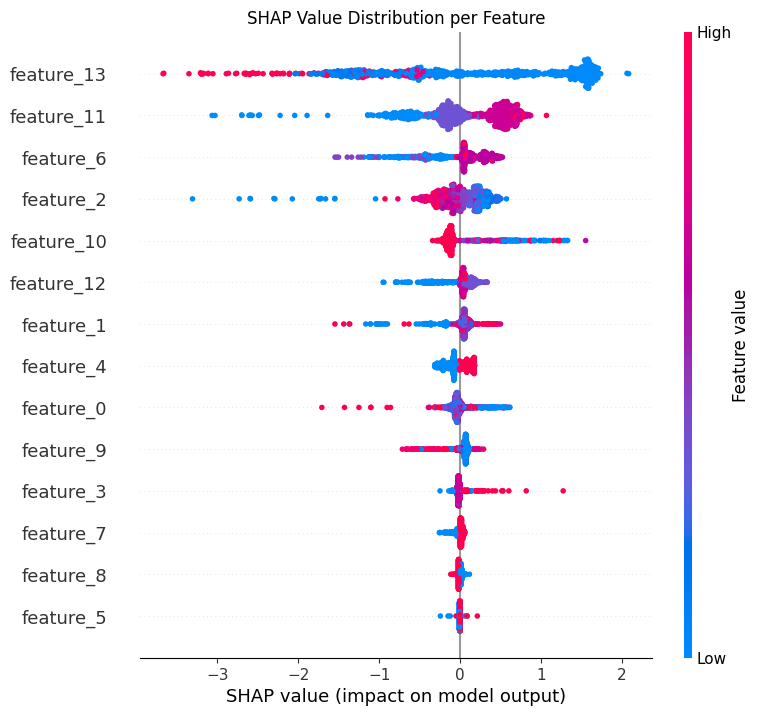

In [128]:
#Summary Plot (Dot) - Shows SHAP value distribution for each feature
if shap_values_train_pos is not None and X_train_transformed_df is not None and feature_names_transformed:
    print("\nGenerating SHAP Summary Plot (Dot)...")
    try:
        shap.summary_plot(shap_values_train_pos, X_train_transformed_df, feature_names=feature_names_transformed, show=False)
        plt.title("SHAP Value Distribution per Feature")
        plt.show()
    except Exception as e_dot:
        print(f"Error generating dot plot: {e_dot}")
else:
    print("Cannot generate dot summary plot: SHAP values, transformed data, or feature names not available.")


## **Local Explainability** <br>
Explain individual predictions from the test set

In [129]:
#Helper function to find indices for TP, TN, FP, FN
def find_instance_indices(y_true, y_pred, X_test_index): # Pass X_test index
    tp_indices = np.where((y_true == 1) & (y_pred == 1))[0]
    tn_indices = np.where((y_true == 0) & (y_pred == 0))[0]
    fp_indices = np.where((y_true == 0) & (y_pred == 1))[0]
    fn_indices = np.where((y_true == 1) & (y_pred == 0))[0]
    #Get original index from X_test index using iloc indices
    tp_orig = X_test_index[tp_indices].tolist()
    tn_orig = X_test_index[tn_indices].tolist()
    fp_orig = X_test_index[fp_indices].tolist()
    fn_orig = X_test_index[fn_indices].tolist()

    return {'TP': tp_indices, 'TN': tn_indices, 'FP': fp_indices, 'FN': fn_indices,
            'TP_orig': tp_orig, 'TN_orig': tn_orig, 'FP_orig': fp_orig, 'FN_orig': fn_orig}

instance_indices = {}
if 'y_pred_clf_fpipe_a' in globals() and y_test is not None:
    instance_indices = find_instance_indices(y_test, y_pred_clf_fpipe_a, X_test.index) # Pass index
    print(f"\nFound {len(instance_indices.get('TN',[]))} TN, {len(instance_indices.get('TP',[]))} TP instances in test set.")
else:
    print("\nPredictions for model 'a' (y_pred_clf_fpipe_a) or y_test not found. Cannot select specific instances.")
    instance_indices = {'TP': [], 'TN': [], 'FP': [], 'FN': [], 'TP_orig': [], 'TN_orig': [], 'FP_orig': [], 'FN_orig': []}


Found 85 TN, 205 TP instances in test set.


In [130]:
#Choose example indices (iloc indices for the test set)
index_tn = instance_indices['TN'][0] if len(instance_indices['TN']) > 0 else None
index_tp = instance_indices['TP'][0] if len(instance_indices['TP']) > 0 else None
#Get corresponding original index if needed (using the lists created above)
orig_index_tn = instance_indices['TN_orig'][0] if index_tn is not None and instance_indices['TN_orig'] else None
orig_index_tp = instance_indices['TP_orig'][0] if index_tp is not None and instance_indices['TP_orig'] else None


--- Explaining True Negative instance (Test Set Index: 1, Original Index: 527) ---
Features (Original):
Group                          Regional ED
Sex                                   Male
Age                                     63
Arrival mode             Private ambulance
Injury                          Non-injury
Chief_complain             ant. chest pain
Mental                               Alert
Pain                                  Pain
SBP                                  140.0
DBP                                  100.0
HR                                    62.0
RR                                    20.0
BT                                    36.2
KTAS_RN                                  2
Diagnosis in ED       Ischaemic chest pain
KTAS_expert                              2
Length of stay_min                   21492
Name: 527, dtype: object
Actual Label: 0 (Admission)
Predicted Label: 0 (Admission)

Force Plot (explaining prediction for Admission=1):



Waterfall Plot (explaining prediction for Admission=1):


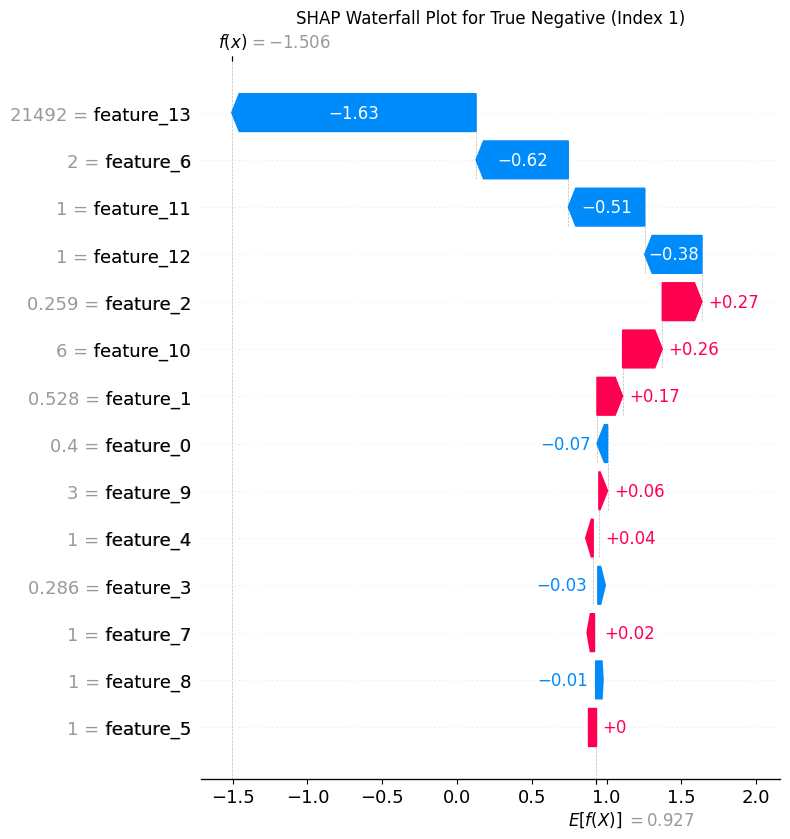

In [131]:
# Explain a True Negative instance (Correctly predicted Discharge - Class 0)
if index_tn is not None and explainer is not None and shap_values_test_pos is not None and X_test_transformed_df is not None:
    # Ensure index is within bounds of calculated SHAP values
    if index_tn < shap_values_test_pos.shape[0]:
        print(f"\n--- Explaining True Negative instance (Test Set Index: {index_tn}, Original Index: {orig_index_tn}) ---")
        if orig_index_tn is not None: print(f"Features (Original):\n{X_test.loc[orig_index_tn]}")
        # print(f"Features (Transformed):\n{X_test_transformed_df.iloc[index_tn]}") # Can be long
        print(f"Actual Label: {y_test[index_tn]} ({le.classes_[y_test[index_tn]]})")
        print(f"Predicted Label: {y_pred_clf_fpipe_a[index_tn]} ({le.classes_[y_pred_clf_fpipe_a[index_tn]]})")

        # Force Plot for TN
        print("\nForce Plot (explaining prediction for Admission=1):")
        # Low output value means prediction is pushed towards Discharge=0
        try:
             display(shap.force_plot(expected_value,
                                     shap_values_test_pos[index_tn,:],
                                     X_test_transformed_df.iloc[index_tn,:],
                                     matplotlib=False)) # Use default JS plot for notebooks
        except Exception as e_force:
             print(f"Error generating force plot for TN: {e_force}")


        # Waterfall Plot for TN
        print("\nWaterfall Plot (explaining prediction for Admission=1):")
        # Features pushing the value down contribute to the Discharge prediction
        try:
            shap_explanation_tn = shap.Explanation(values=shap_values_test_pos[index_tn,:],
                                            base_values=expected_value,
                                            data=X_test_transformed_df.iloc[index_tn,:].values, # Pass values
                                            feature_names=feature_names_transformed)
            shap.waterfall_plot(shap_explanation_tn,
                                max_display=15, # Limit number of features shown
                                show=False)
            plt.title(f"SHAP Waterfall Plot for True Negative (Index {index_tn})")
            plt.tight_layout()
            plt.show()
        except Exception as e_waterfall:
            print(f"Error generating waterfall plot for TN: {e_waterfall}")
            # Try legacy waterfall
            try:
                print("Trying legacy waterfall plot...")
                shap.plots._waterfall.waterfall_legacy(expected_value, shap_values_test_pos[index_tn,:], feature_names=feature_names_transformed, max_display=15, show=False)
                plt.title(f"SHAP Waterfall Plot (Legacy) for True Negative (Index {index_tn})")
                plt.tight_layout()
                plt.show()
            except Exception as e_waterfall_legacy:
                print(f"Legacy waterfall plot also failed for TN: {e_waterfall_legacy}")

    else:
         print(f"\nIndex {index_tn} is out of bounds for the calculated SHAP test values (shape: {shap_values_test_pos.shape}). Maybe KernelExplainer used a subset?")

else:
    print("\nCannot explain True Negative: Index not found, SHAP values missing, or explainer not available.")


--- Explaining True Positive instance (Test Set Index: 0, Original Index: 615) ---
Features (Original):
Group                    Local ED
Sex                        Female
Age                            50
Arrival mode          Private car
Injury                     Injury
Chief_complain             Others
Mental                      Alert
Pain                         Pain
SBP                         166.0
DBP                          80.0
HR                           61.0
RR                           20.0
BT                           37.0
KTAS_RN                         4
Diagnosis in ED            Others
KTAS_expert                     4
Length of stay_min            182
Name: 615, dtype: object
Actual Label: 1 (Discharge)
Predicted Label: 1 (Discharge)

Force Plot (explaining prediction for Admission=1):



Waterfall Plot (explaining prediction for Admission=1):


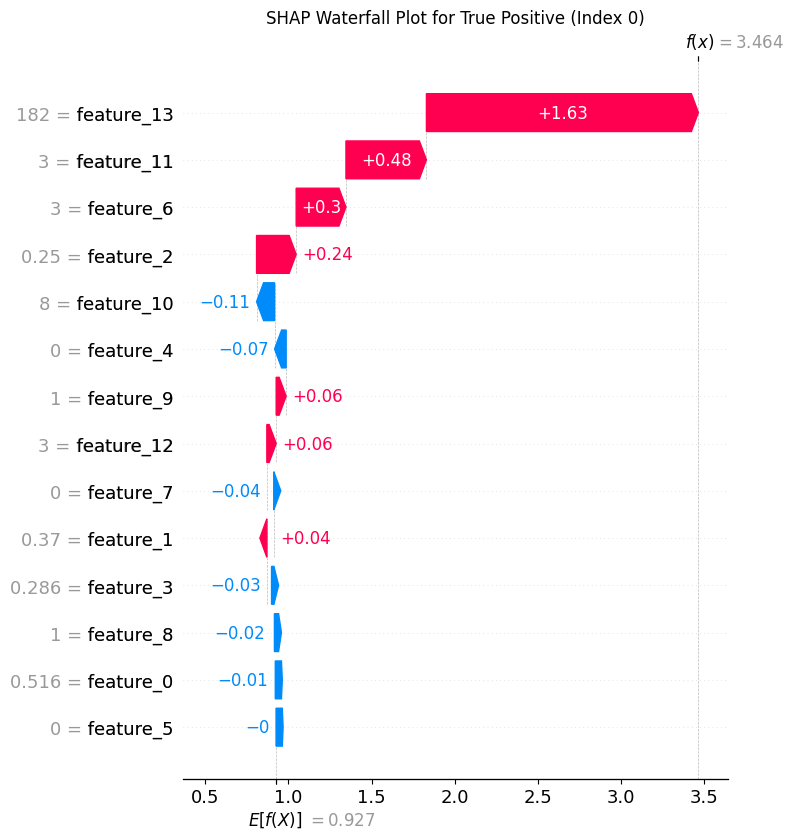

In [132]:
# Explain a True Positive instance (Correctly predicted Admission - Class 1)
if index_tp is not None and explainer is not None and shap_values_test_pos is not None and X_test_transformed_df is not None:
    # Ensure index is within bounds of calculated SHAP values
     if index_tp < shap_values_test_pos.shape[0]:
        print(f"\n--- Explaining True Positive instance (Test Set Index: {index_tp}, Original Index: {orig_index_tp}) ---")
        if orig_index_tp is not None: print(f"Features (Original):\n{X_test.loc[orig_index_tp]}")
        # print(f"Features (Transformed):\n{X_test_transformed_df.iloc[index_tp]}")
        print(f"Actual Label: {y_test[index_tp]} ({le.classes_[y_test[index_tp]]})")
        print(f"Predicted Label: {y_pred_clf_fpipe_a[index_tp]} ({le.classes_[y_pred_clf_fpipe_a[index_tp]]})")

        # Force Plot for TP
        print("\nForce Plot (explaining prediction for Admission=1):")
        # High output value means prediction is pushed towards Admission=1
        try:
            display(shap.force_plot(expected_value,
                                    shap_values_test_pos[index_tp,:],
                                    X_test_transformed_df.iloc[index_tp,:],
                                    matplotlib=False))
        except Exception as e_force:
            print(f"Error generating force plot for TP: {e_force}")

        # Waterfall Plot for TP
        print("\nWaterfall Plot (explaining prediction for Admission=1):")
        # Features pushing the value up contribute to the Admission prediction
        try:
            shap_explanation_tp = shap.Explanation(values=shap_values_test_pos[index_tp,:],
                                            base_values=expected_value,
                                            data=X_test_transformed_df.iloc[index_tp,:].values, # Pass values
                                            feature_names=feature_names_transformed)
            shap.waterfall_plot(shap_explanation_tp,
                                max_display=15,
                                show=False)
            plt.title(f"SHAP Waterfall Plot for True Positive (Index {index_tp})")
            plt.tight_layout()
            plt.show()
        except Exception as e_waterfall:
             print(f"Error generating waterfall plot for TP: {e_waterfall}")
             # Try legacy waterfall
             try:
                 print("Trying legacy waterfall plot...")
                 shap.plots._waterfall.waterfall_legacy(expected_value, shap_values_test_pos[index_tp,:], feature_names=feature_names_transformed, max_display=15, show=False)
                 plt.title(f"SHAP Waterfall Plot (Legacy) for True Positive (Index {index_tp})")
                 plt.tight_layout()
                 plt.show()
             except Exception as e_waterfall_legacy:
                 print(f"Legacy waterfall plot also failed for TP: {e_waterfall_legacy}")
     else:
          print(f"\nIndex {index_tp} is out of bounds for the calculated SHAP test values (shape: {shap_values_test_pos.shape}). Maybe KernelExplainer used a subset?")

else:
    print("\nCannot explain True Positive: Index not found, SHAP values missing, or explainer not available.")